# Fruit Classification Model

In [1]:
import os
import random

from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from utils import Data, Model

Using TensorFlow backend.


In [2]:
#Keras reproducibility (without GPU)

# Set seeds
np.random.seed(42)
random.seed(12345)

# Force TensorFlow to use single thread.
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

## 1. Data

- 350 images of apples, oranges and pears each scrapped using google_images_download using the keywords 'apples fruit', 'oranges fruit' and 'pear fruit'
- Checking your chrome version https://www.whatismybrowser.com/detect/what-version-of-chrome-do-i-have and download the correct chromedriver here: http://chromedriver.chromium.org/downloads
- Images cleaned (RGB only) and processed by resizing to 244 X 244 (centered)
- Images stored as pickle files (300 X 244 X 244 X 3 np arrays) and uploaded to dropbox (publicly accessible).
- Load pickle files into jupyter notebook from dropbox using wget.
- Format the 3 arrays into a single dataset with labels and perform train-val split of 70:30 for evaluation of model

In [3]:
data = Data(fruit_classes=['apples','oranges','pears'])

# Use wget to download pickle files from google
data.get_data()

# Unpickle to get np array for each fruit 
data.unpickle()

#Format into a single dataset with labels and split data into train and val set
num_images = 10
test_size = 0.3

x_train, x_val, y_train, y_val = data.format_split(num_images,test_size)

### 2.3 Train model

- Transfer learning using pre-trained VGG-16 model (only training the FC layers)
- Set up as a multiclass classification problem with 3 classes: Apples, Oranges, Pears
- Trained model saved as model.h5 file, evaluated by validation loss and validation accuracy

In [4]:
#Define model architecture and compile model

## Architecture
# initializer(str): to be used to initialize hidden units
# activation_func(str): to be used as activation function for all FC layers except the last layer
# regparam(str): L2 regularization parameters for all FC layers
# last_layer_activation(str): activation function for the last layer. 'softmax' for multiclass, 'sigmoid' for binary

## Model Compile
# loss_func(str): loss function used for back propagation
# metric(str): metric used for evaluation

model = Model(initializer='he_normal', activation_func='relu', regparam=5e-3, last_layer_activation='softmax', 
              loss_func='categorical_crossentropy', metric='accuracy')

model.model.summary()

58892288/58889256 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1605696   
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (De

In [5]:
#Define model utils for training model (Image generator for data augmentation, learning rate schedule and model save checkpoint)

## Image generator
# rotation_range(int): rotation range for data augmentation
# horizontal_flip(bool): whether to include horizontal flip for data augmentation

## Model save checkpoint
# model_save(str): file name for model file to be saved at checkpoint
# monitor(str): metric to monitor to determine best model
# mode(str): mode for monitor metric
# period(int): number of epochs to check best checkpoint

model.model_utils(rotation_range=10, horizontal_flip=True, 
                    model_save='model.h5', monitor='val_loss', mode='min', period=1)

#model_fit
model.fit(x_train, y_train, x_val, y_val, batch_size=8, epochs=2, verbose=1)

Epoch 1/2
3/2 [==================================] - 32s 11s/step - loss: 2.0094 - acc: 0.5065 - val_loss: 1.3768 - val_acc: 0.6667
Epoch 2/2
3/2 [==================================] - 31s 10s/step - loss: 1.2903 - acc: 0.6792 - val_loss: 1.0330 - val_acc: 0.7778


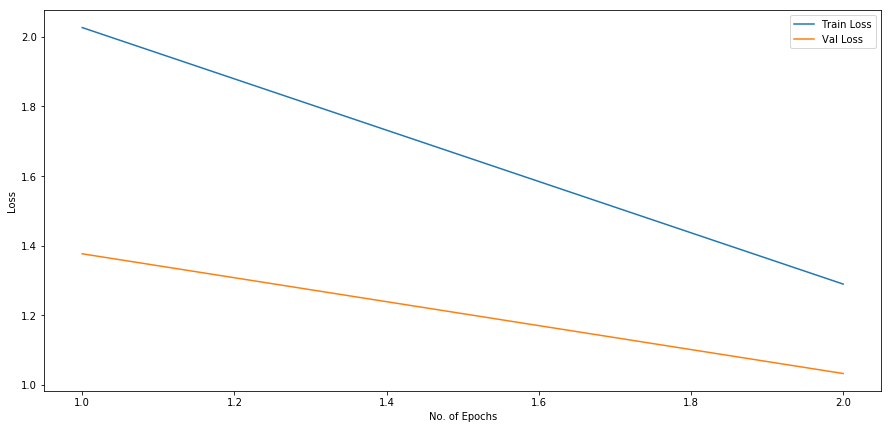

In [6]:
#Learning Curves
def plot_learning_curves(modelfit):
    '''Plot learning curves of model during training'''

    #Get data from modelfit and put them into a summary dataframe
    trainloss = pd.DataFrame(modelfit.history['loss'])
    trainacc = pd.DataFrame(modelfit.history['acc'])
    valloss = pd.DataFrame(modelfit.history['val_loss'])
    valacc = pd.DataFrame(modelfit.history['val_acc'])

    summary = pd.concat([trainloss,trainacc,valloss,valacc],axis=1)
    summary.columns = ["train loss","train acc","val loss","val acc"]

    #Plot learning curves
    f, ax = plt.subplots(figsize=(15, 7))
    plt.plot(summary.index+1,summary['train loss'],label='Train Loss')
    plt.plot(summary.index+1,summary['val loss'],label='Val Loss')
    x_axis = plt.xlabel('No. of Epochs')
    y_axis = plt.ylabel('Loss')
    plt.legend()
    plt.show()        

plot_learning_curves(model.modelfit)

In [8]:
#Evaluate model saved in h5 file
evaluate = model.evaluate(x_val, y_val, model_save='model.h5')

print('Validation Loss: {0}'.format(evaluate[0]))
print('Validation Accuracy: {0}'.format(evaluate[1]))

9/9 [==============================] - 9s 1s/step
Validation Loss: 1.032993197441101
Validation Accuracy: 0.7777777910232544
